In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
df = pd.read_csv("/kaggle/input/world-happiness/2019.csv")

In [ ]:
df
scores = df["Score"]

* After clustering we will check the result with scores list

In [ ]:
df = df.drop(columns = ["Overall rank", "Country or region", "Score"])

In [ ]:
df = (df - np.min(df)) / (np.max(df) - np.min(df))

Normalization

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,10):
    km = KMeans(n_clusters=i).fit(df)
    wcss.append(km.inertia_)
plt.plot(np.arange(1,len(wcss)+1), wcss)

* elbow point is 3[](http://)

* we can split our data happy, normal, unhappy

In [ ]:
km = KMeans(n_clusters=3).fit(df)

In [ ]:
df["label"] = km.predict(df)

In [ ]:
happy_num = df["label"][0]
unhappy_num = df["label"][155]
normal_num = -1
for i in range(3):
    if i != happy_num and i != unhappy_num:
        normal_num = i

In [ ]:
happy_num, unhappy_num, normal_num

In [ ]:
df.label.values

In [ ]:
plt.scatter(df[df.label == happy_num].index,scores[df[df.label == happy_num].index], color="yellow", label = "Happy")
plt.scatter(df[df.label == normal_num].index,scores[df[df.label == normal_num].index], color="blue", label = "Normal")
plt.scatter(df[df.label == unhappy_num].index,scores[df[df.label == unhappy_num].index], color="red", label = "Unhappy")
plt.legend()
plt.title("KMean Clustering")
plt.ylabel("Scores")
plt.show()

Now let's look hierarchical clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
ward = AgglomerativeClustering(n_clusters=3,linkage='ward').fit(df)
h = ward.labels_

In [ ]:
h = pd.DataFrame(h)
happy_num2 = h[0][0]
unhappy_num2 = h[0][155]
normal_num2 = -1
for i in range(3):
    if i != happy_num2 and i != unhappy_num2:
        normal_num2 = i
plt.scatter(h[h[0] == happy_num2].index,scores[h[h[0] == happy_num2].index], color="yellow", label = "Happy")
plt.scatter(h[h[0] == normal_num2].index,scores[h[h[0] == normal_num2].index], color="blue", label = "Normal")
plt.scatter(h[h[0] == unhappy_num2].index,scores[h[h[0] == unhappy_num2].index], color="red", label = "Unhappy")
plt.legend()
plt.title("Hierarchical Clustering")
plt.ylabel("Scores")
plt.show()

In [ ]:
def flag(x):
    if x == happy_num:
        return "Happy"
    elif x == normal_num:
        return "Normal"
    return "Unhappy"
df["happiness"] = df["label"].apply(lambda x : flag(x))
df

In [ ]:
from sklearn.model_selection import train_test_split
y = df["label"]
x = df.drop(columns = ["happiness","label"])
y.values

* first divide happy and others (normal, unhappy)

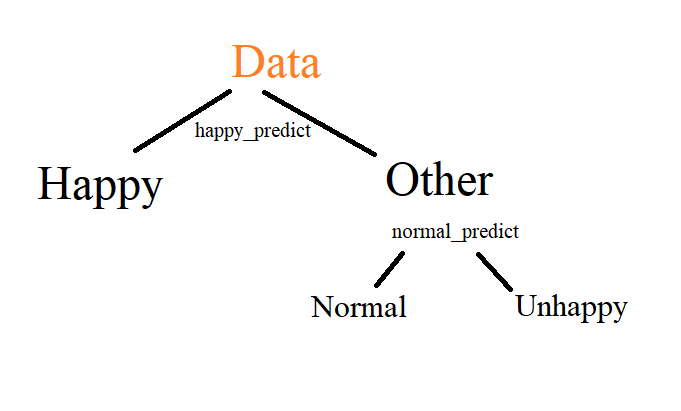

In [ ]:
y1 = y.apply(lambda x : 1 if x == happy_num else 0)
x_test, x_train, y_test, y_train = train_test_split(x, y1, test_size = 0.2)

In [ ]:
from sklearn.linear_model import LogisticRegression
happy_predict = LogisticRegression().fit(x_train, y_train)

* Happy predict find just happy countries

In [ ]:
y2 = y[y != happy_num].apply(lambda x : 1 if x == normal_num else 0)

* We must remove happy countries from data for normal prediction

In [ ]:
x2 = df[df["label"] != happy_num].drop(columns = ["happiness", "label"])
x_test, x_train, y_test, y_train = train_test_split(x2, y2, test_size = 0.2)
normal_predict = LogisticRegression().fit(x_train, y_train)

In [ ]:
happies = happy_predict.predict(x)
happies

In [ ]:
normals = normal_predict.predict(x)
normals

In [ ]:
normals.shape

In [ ]:
result = np.full(normals.shape, -1)

In [ ]:
result

In [ ]:
for i in range(happies.shape[0]):
    if happies[i] == 1:
        result[i] = happy_num
result

In [ ]:
for i in range(normals.shape[0]):
    if result[i] == happy_num:
        continue
    elif normals[i] == 1:
        result[i] = normal_num
    else:
        result[i] = unhappy_num
result

In [ ]:
df["predict_label"] = result.astype(int)

In [ ]:
df

In [ ]:
accuracy = (df["label"] == df["predict_label"])

In [ ]:
print("Accuracy : %",accuracy.values.sum() / accuracy.size * 100)

With K-Nearest Learning

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.2)

In [ ]:
y_train

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Lets find best neighbor number for KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
knn_cv = GridSearchCV(KNeighborsClassifier(), {"n_neighbors" : np.arange(1,50)}, cv = 10)
knn_cv.fit(x_train, y_train)
best_n = knn_cv.best_params_["n_neighbors"]
knn_cv.best_params_

In [ ]:
knn = KNeighborsClassifier(n_neighbors=best_n).fit(x_train,y_train)
print("KNN Accuracy : %",knn.score(x_test, y_test)*100)